# Кольцевое бета-распределение каршеринговых машин по Москве + заправки

Этот ноутбук:

1. Генерирует гладкое двумерное распределение каршеринговых машин вокруг центра Москвы
   с помощью бета-распределения по радиусу.
2. Загружает датасет с координатами заправок и ценами.
3. Удаляет дубликаты заправок по координатам и оставляет только заправки,
   находящиеся **не дальше 5 км от МКАД** (Москва + ближайшее Подмосковье).
4. Визуализирует одновременно машины и заправки на карте Москвы с контурами
   Садового кольца, ТТК и МКАД.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import cos
import math
import statistics

# -----------------------
# Конфигурация модели
# -----------------------

CONFIG = {
    "city": "Moscow",
    "random_seed": 42,
    # Центр Москвы (примерно Кремль)
    "city_center": {"lat": 55.7558, "lon": 37.6176},
    # Радиусы основных колец (км)
    "rings_km": {
        "sadovoe": 2.2,
        "ttk": 5.0,
        "mkad": 16.5,
    },
    # Минимальный радиус, внутри которого машин почти нет (запрет парковки)
    "min_radius_km": 1.0,
    # Максимальный радиус, до которого моделируем город (чуть дальше МКАД)
    "max_radius_km": 20.0,
    # Объем бака машины (л)
    "tank_volume_l": 50,
    # Варианты размеров парка
    "fleet_sizes": [500, 5000, 1500],
    # Распределение уровня заправленности (доля бака)
    # Вероятности задаются через поле share.
    "fuel_level_distribution": [
        {"range": [0.0, 0.1], "share": 0.01},  # < 10% бака — 1% парка
        {"range": [0.1, 0.2], "share": 0.03},  # 10–20% — 3% парка
        {"range": [0.2, 0.5], "share": 0.20},  # 20–50% — 20% парка
        # Остальные (1 - сумма share) будут иметь уровень [0.5, 1.0]
    ],
    # Радиальное распределение по времени суток (бета-распределение)
    "radial_beta_scenarios": {
        "morning": {
            # Пик между Садовым и ТТК, небольшой хвост к МКАД
            "alpha": 2.1,
            "beta": 4.0,
        },
        "evening": {
            # Более широкое распределение, больше массы ближе к МКАД
            "alpha": 5.0,
            "beta": 2.0,
        },
    },
}

np.random.seed(CONFIG["random_seed"])

In [ ]:
from math import radians, sqrt

# ---- Вспомогательные функции для координат ----

def km_to_deg_lat(km: float) -> float:
    """Перевод километров в градусы широты (приблизительно)."""
    return km / 111.0

def km_to_deg_lon(km: float, lat_deg: float) -> float:
    """Перевод километров в градусы долготы (приблизительно)."""
    return km / (111.0 * np.cos(np.radians(lat_deg)))

def deg_to_km(center_lat, center_lon, lat, lon):
    """Грубая оценка расстояния в км от центра до точки (lat, lon)
    в проекции на плоскость."""
    dlat_km = (lat - center_lat) * 111.0
    dlon_km = (lon - center_lon) * 111.0 * np.cos(np.radians(center_lat))
    return np.sqrt(dlat_km**2 + dlon_km**2)

# ---- Радиальное бета-распределение ----

def sample_radii_beta(n_points, scenario_cfg, min_radius_km, max_radius_km):
    """Генерация радиусов r (км) из бета-распределения на [min_radius_km, max_radius_km]."""
    alpha = scenario_cfg["alpha"]
    beta = scenario_cfg["beta"]
    x = np.random.beta(alpha, beta, size=n_points)  # на [0, 1]
    r = min_radius_km + x * (max_radius_km - min_radius_km)
    return r

def sample_positions_beta_ring(center_lat, center_lon, n_points, scenario_name, config=CONFIG):
    """Генерируем точки:
    1. Сэмплим радиус r по бета-распределению.
    2. Сэмплим угол θ ~ U(0, 2π).
    3. Переводим (r, θ) в lat/lon.
    """
    scenario_cfg = config["radial_beta_scenarios"][scenario_name]
    min_r = config["min_radius_km"]
    max_r = config["max_radius_km"]

    # Радиусы и углы
    r_km = sample_radii_beta(n_points, scenario_cfg, min_r, max_r)
    theta = np.random.uniform(0.0, 2.0 * np.pi, size=n_points)

    # Декартовы смещения в км
    x_km = r_km * np.cos(theta)
    y_km = r_km * np.sin(theta)

    # Перевод в градусы
    lat_offsets_deg = km_to_deg_lat(y_km)
    lon_offsets_deg = km_to_deg_lon(x_km, center_lat)

    lats = center_lat + lat_offsets_deg
    lons = center_lon + lon_offsets_deg
    return lats, lons, r_km

def generate_positions(n_cars, scenario_name, config=CONFIG):
    """Позиции машин: бета-распределение по радиусу + равномерный угол."""
    center = config["city_center"]
    lats, lons, r_km = sample_positions_beta_ring(center["lat"], center["lon"], n_cars, scenario_name, config)
    return lats, lons, r_km

# ---- Уровни топлива ----

def generate_fuel_levels(n_cars, config=CONFIG):
    """Генерация уровня топлива (доля бака) и требуемого долива (л).

    Распределение:
    - < 10% бака — 1% парка
    - 10–20%     — 3% парка
    - 20–50%     — 20% парка
    - остальное  — [0.5, 1.0]
    """
    dist = config["fuel_level_distribution"]
    tank_volume = config["tank_volume_l"]

    shares = [item["share"] for item in dist]
    ranges = [item["range"] for item in dist]
    thresholds = np.cumsum(shares)

    fuel_levels = np.empty(n_cars)
    u = np.random.rand(n_cars)

    for i in range(n_cars):
        x = u[i]
        if x < thresholds[0]:
            low, high = ranges[0]
        elif x < thresholds[1]:
            low, high = ranges[1]
        elif x < thresholds[2]:
            low, high = ranges[2]
        else:
            low, high = 0.5, 1.0
        fuel_levels[i] = np.random.uniform(low, high)

    needed_liters = (1.0 - fuel_levels) * tank_volume
    need_refuel = fuel_levels < 0.5
    return fuel_levels, needed_liters, need_refuel

def simulate_fleet(n_cars, scenario_name, config=CONFIG):
    """Полная симуляция: позиции + топливо."""
    lats, lons, r_km = generate_positions(n_cars, scenario_name, config)
    fuel_levels, needed_liters, need_refuel = generate_fuel_levels(n_cars, config)

    df = pd.DataFrame({
        "car_id": np.arange(n_cars),
        "time_of_day": scenario_name,
        "lat": lats,
        "lon": lons,
        "radius_km": r_km,
        "fuel_level": fuel_levels,
        "needed_liters": needed_liters,
        "need_refuel": need_refuel,
    })
    return df

# ---- Окружности и карты ----

def circle_points(center_lat, center_lon, radius_km, num_points=360):
    """Координаты окружности радиуса radius_km вокруг центра."""
    angles = np.linspace(0, 2 * np.pi, num_points)
    x_km = radius_km * np.cos(angles)
    y_km = radius_km * np.sin(angles)

    lat_offsets_deg = km_to_deg_lat(y_km)
    lon_offsets_deg = km_to_deg_lon(x_km, center_lat)

    lats = center_lat + lat_offsets_deg
    lons = center_lon + lon_offsets_deg
    return lats, lons

def plot_map_with_rings_and_stations(df_cars,
                                     df_stations,
                                     title,
                                     config=CONFIG,
                                     routes_by_station=None):
    """
    Карта с машинами, заправками, кольцами и (опционально) маршрутами бензовозов.

    routes_by_station: словарь {station_id: [ [индексы машин из df_cars], ... ]}
    """
    center = config["city_center"]
    rings = config["rings_km"]

    plt.figure(figsize=(6, 6))
    # Заправки
    plt.scatter(df_stations["lon"], df_stations["lat"], s=12, alpha=0.8, marker="^", label="АЗС")
    # Машины
    plt.scatter(df_cars["lon"], df_cars["lat"], s=3, alpha=0.3, label="Машины")

    # Кольца
    sad_lats, sad_lons = circle_points(center["lat"], center["lon"], rings["sadovoe"])
    ttk_lats, ttk_lons = circle_points(center["lat"], center["lon"], rings["ttk"])
    mkad_lats, mkad_lons = circle_points(center["lat"], center["lon"], rings["mkad"])

    plt.plot(sad_lons, sad_lats, linewidth=1.5, label="Садовое кольцо")
    plt.plot(ttk_lons, ttk_lats, linewidth=1.5, label="ТТК")      # <-- тут было ttk_lons
    plt.plot(mkad_lons, mkad_lats, linewidth=1.5, label="МКАД")

    plt.scatter([center["lon"]], [center["lat"]], marker="x", s=80, label="Центр города")

    # Маршруты бензовозов (если переданы)
    if routes_by_station is not None:
        for station_id, trips in routes_by_station.items():
            if "station_id" in df_stations.columns:
                st_row = df_stations[df_stations["station_id"] == station_id].iloc[0]
            else:
                st_row = df_stations.loc[station_id]

            st_lat = st_row["lat"]
            st_lon = st_row["lon"]

            for trip in trips:
                lats = [st_lat]
                lons = [st_lon]
                for car_idx in trip:
                    car_row = df_cars.loc[car_idx]
                    lats.append(car_row["lat"])
                    lons.append(car_row["lon"])
                lats.append(st_lat)
                lons.append(st_lon)
                plt.plot(lons, lats, linewidth=0.8, alpha=0.7)

    plt.xlabel("Долгота")
    plt.ylabel("Широта")
    plt.title(title)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


def plot_fuel_histogram(df, title):
    """Гистограмма распределения уровня топлива."""
    plt.figure(figsize=(6, 4))
    plt.hist(df["fuel_level"], bins=20)
    plt.xlabel("Уровень топлива (доля бака)")
    plt.ylabel("Количество машин")
    plt.title(title)
    plt.grid(True)
    plt.show()

def print_ring_stats(df, config=CONFIG):
    """Доля машин в диапазонах: до Садового, между Садовым и ТТК, между ТТК и МКАД, за МКАД."""
    rings = config["rings_km"]
    r = df["radius_km"].values

    sad = rings["sadovoe"]
    ttk = rings["ttk"]
    mkad = rings["mkad"]

    inner = r < sad
    sad_ttk = (r >= sad) & (r < ttk)
    ttk_mkad = (r >= ttk) & (r < mkad)
    outside = r >= mkad

    n = len(r)
    print(f"Всего машин: {n}")
    print(f"  Внутри Садового (< {sad} км): {inner.mean():.3f}")
    print(f"  Между Садовым и ТТК ([{sad}, {ttk}) км): {sad_ttk.mean():.3f}")
    print(f"  Между ТТК и МКАД ([{ttk}, {mkad}) км): {ttk_mkad.mean():.3f}")
    print(f"  За МКАД (>= {mkad} км): {outside.mean():.3f}")

In [ ]:
# Загрузка датасета с заправками и фильтрация по расстоянию от МКАД

stations_csv_path = "moscow_stations.csv"  # путь поправь под себя, если нужно

df_stations_raw = pd.read_csv(stations_csv_path)
print("Всего записей в датасете заправок:", len(df_stations_raw))
print(df_stations_raw.head())

# Убираем дубликаты по координатам
df_stations = df_stations_raw.drop_duplicates(subset=["lat", "lon"]).copy()
print("Уникальных заправок по координатам до фильтрации:", len(df_stations))

# Радиус от центра для каждой заправки
center_lat = CONFIG["city_center"]["lat"]
center_lon = CONFIG["city_center"]["lon"]
mkad_r = CONFIG["rings_km"]["mkad"]
buffer_km = 5.0  # не дальше чем 5 км от МКАД

df_stations["radius_km"] = deg_to_km(center_lat, center_lon,
                                     df_stations["lat"].values,
                                     df_stations["lon"].values)

mask = df_stations["radius_km"] <= mkad_r + buffer_km
df_stations = df_stations[mask].copy()

print("АЗС после фильтрации (<= МКАД + 5 км):", len(df_stations))

Всего записей в датасете заправок: 1359
         lat        lon  price
0  54.936169  37.530037  60.01
1  55.886448  38.169321  67.80
2  54.936610  37.527840  60.01
3  55.875330  38.199880  60.34
4  55.450078  37.527992  59.90
Уникальных заправок по координатам до фильтрации: 1313
АЗС после фильтрации (<= МКАД + 5 км): 504


Симуляция для парка из 5000 машин

=== Утро ===
Всего машин: 5000
  Внутри Садового (< 2.2 км): 0.026
  Между Садовым и ТТК ([2.2, 5.0) км): 0.223
  Между ТТК и МКАД ([5.0, 16.5) км): 0.746
  За МКАД (>= 16.5 км): 0.006


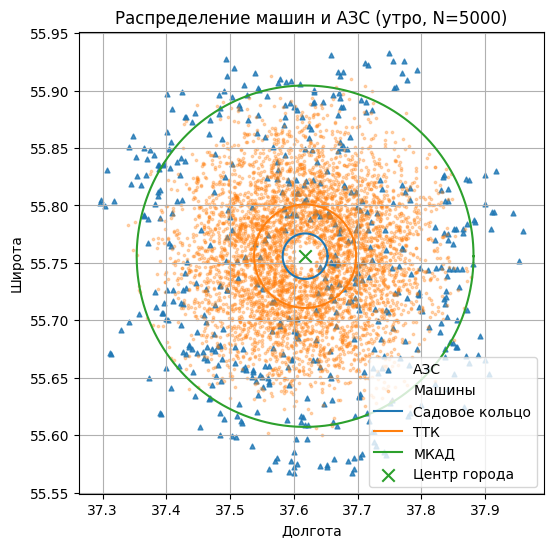

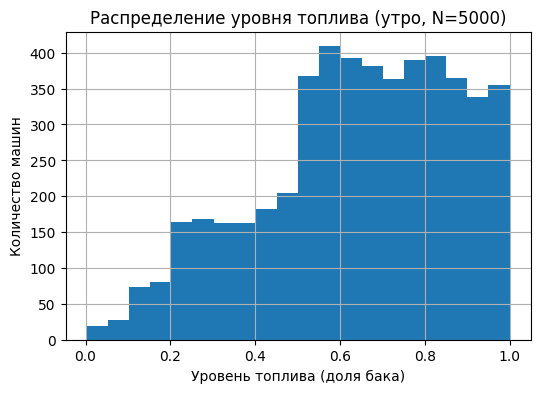


=== Вечер ===
Всего машин: 5000
  Внутри Садового (< 2.2 км): 0.000
  Между Садовым и ТТК ([2.2, 5.0) км): 0.002
  Между ТТК и МКАД ([5.0, 16.5) км): 0.682
  За МКАД (>= 16.5 км): 0.316


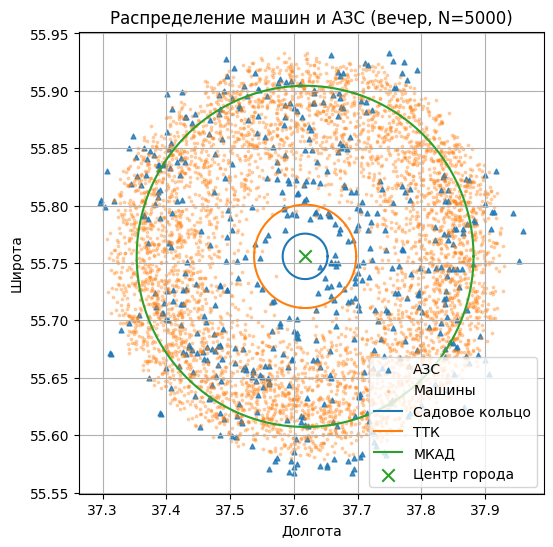

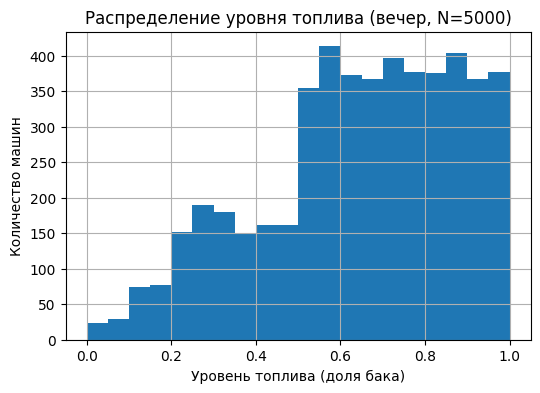

In [ ]:
# Пример: парк 10 000 машин, утро и вечер + отфильтрованные заправки

fleet_size = CONFIG["fleet_sizes"][1]  # 10 000
print(f"Симуляция для парка из {fleet_size} машин")

df_morning = simulate_fleet(fleet_size, "morning", CONFIG)
df_evening = simulate_fleet(fleet_size, "evening", CONFIG)

print("\n=== Утро ===")
print_ring_stats(df_morning, CONFIG)
plot_map_with_rings_and_stations(df_morning, df_stations,
                                 f"Распределение машин и АЗС (утро, N={fleet_size})", CONFIG)
plot_fuel_histogram(df_morning, f"Распределение уровня топлива (утро, N={fleet_size})")

print("\n=== Вечер ===")
print_ring_stats(df_evening, CONFIG)
plot_map_with_rings_and_stations(df_evening, df_stations,
                                 f"Распределение машин и АЗС (вечер, N={fleet_size})", CONFIG)
plot_fuel_histogram(df_evening, f"Распределение уровня топлива (вечер, N={fleet_size})")

In [ ]:
# Сохранение датасетов машин (координаты + уровень заправленности) в CSV

# Можно переопределить fleet_size выше и заново пересимулировать парк,
# тогда здесь просто сохраняем актуальные df_morning и df_evening.

cols = ["car_id", "time_of_day", "lat", "lon", "fuel_level", "needed_liters", "need_refuel"]

output_morning = "cars_morning_{}k.csv".format(fleet_size // 1000)
output_evening = "cars_evening_{}k.csv".format(fleet_size // 1000)

df_morning[cols].to_csv(output_morning, index=False)
df_evening[cols].to_csv(output_evening, index=False)

print("Сохранён файл с утренним парком:", output_morning)
print("Сохранён файл с вечерним парком:", output_evening)

Сохранён файл с утренним парком: cars_morning_5k.csv
Сохранён файл с вечерним парком: cars_evening_5k.csv


In [ ]:
from math import sqrt
from typing import List

class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Car():
    def __init__(self, point, fuel_need):
        self.point = point
        self.fuel_need = fuel_need

class Tanker():
    def __init__(self, max_fuel_cap):
        self.max_fuel_cap = max_fuel_cap

# Константы для оценки стоимости
TANKER_CONSUMPTION_L_PER_100KM = 35.0   # средний расход бензовоза, л/100 км
AVERAGE_FUEL_PRICE_RUB_PER_L  = 65.0    # средняя цена бензина, ₽/л

def get_distance_cost(point1, point2):
    """
    Возвращает денежную стоимость проезда бензовоза от point1 до point2.

    - расстояние считаем по метрике Манхэттена (|dx| + |dy|), в КИЛОМЕТРАХ;
    - далее переводим км -> литры по фиксированному расходу;
    - литры -> рубли по средней цене бензина.
    """
    # Манхэттен-расстояние в км (предполагаем, что point.x/point.y уже в км)
    dx = abs(point1.x - point2.x)
    dy = abs(point1.y - point2.y)
    distance_km = dx + dy

    # Сколько литров сожрёт бензовоз на этом участке
    liters_used = distance_km * (TANKER_CONSUMPTION_L_PER_100KM / 100.0)

    # Денежная стоимость
    money_cost_rub = liters_used * AVERAGE_FUEL_PRICE_RUB_PER_L
    return money_cost_rub

In [ ]:
# ---------------- Новое: привязка машин к АЗС и расчёт суммарной стоимости ----------------

def add_xy_km(df, center_lat=CONFIG["city_center"]["lat"], center_lon=CONFIG["city_center"]["lon"]):
    """
    Добавляем приближённые декартовы координаты (x_km, y_km) в километрах
    относительно центра города.
    """
    df = df.copy()
    df["x_km"] = (df["lon"] - center_lon) * 111.0 * np.cos(np.radians(center_lat))
    df["y_km"] = (df["lat"] - center_lat) * 111.0
    return df


def assign_nearest_station(df_cars, df_stations):
    """
    Для каждой машины находим ближайшую АЗС по евклидовому расстоянию в (x_km, y_km).
    Возвращает копию df_cars с колонкой station_id.
    """
    cars = df_cars.copy()
    stations = df_stations.copy().reset_index(drop=True)
    stations["station_id"] = stations.index

    cars_xy = cars[["x_km", "y_km"]].to_numpy()
    stations_xy = stations[["x_km", "y_km"]].to_numpy()

    # distances_sq: shape (n_cars, n_stations)
    diff = cars_xy[:, None, :] - stations_xy[None, :, :]
    distances_sq = np.sum(diff ** 2, axis=2)
    nearest_idx = np.argmin(distances_sq, axis=1)

    cars["station_id"] = nearest_idx
    return cars, stations

In [ ]:
def compute_total_cost_for_fleet(df_cars,
                                 df_stations,
                                 tanker_capacity_liters=300.0,
                                 only_need_refuel=True):
    """
    1) Каждую машину относим к ближайшей АЗС (по x_km, y_km — функции add_xy_km/assign_nearest_station).
    2) Для каждой АЗС строим оптимальный объезд машин (get_tour_cost).
    3) Считаем:
         общая_стоимость = сумма по АЗС (стоимость_проезда + стоимость_топлива).

    Ожидается, что:
      - в df_stations есть колонка 'price' — цена литра,
      - в df_cars — 'needed_liters' и 'need_refuel'.

    Возвращает:
      total_cost,
      df_cars_assigned (с station_id),
      df_stations_with_id (с station_id),
      routes_by_station: {station_id: [ [индексы машин в df_cars], ... ] }
    """

    # Добавляем x_km, y_km
    cars_xy = add_xy_km(df_cars)
    stations_xy = add_xy_km(df_stations)

    # Можно учитывать только машины, которые реально нужно заправлять
    if only_need_refuel:
        cars_xy = cars_xy[cars_xy["need_refuel"]].copy()

    # Привязываем к ближайшей АЗС
    cars_assigned, stations_with_id = assign_nearest_station(cars_xy, stations_xy)

    total_cost = 0.0
    tanker = Tanker(tanker_capacity_liters)
    routes_by_station = {}

    for station_id, group in cars_assigned.groupby("station_id"):
        if group.empty:
            continue

        station_row = stations_with_id.loc[station_id]
        station_price = float(station_row["price"])  # колонка цены в moscow_stations.csv

        # Точка АЗС в координатах (км)
        fuel_station_point = Point(station_row["x_km"], station_row["y_km"])

        # Машины для алгоритма get_tour_cost
        cars_for_tour = []
        idx_list = []  # индексы строк df_cars (они же индексы cars_assigned)
        for idx, row in group.iterrows():
            fuel_need = float(row["needed_liters"])
            if fuel_need <= 0:
                continue
            car_point = Point(row["x_km"], row["y_km"])
            cars_for_tour.append(Car(car_point, fuel_need))
            idx_list.append(idx)

        if not cars_for_tour:
            continue

        # Стоимость маршрута бензовоза (проезд) и локальные маршруты
        tour_cost, routes_local = get_tour_cost(fuel_station_point, cars_for_tour, tanker)

        # Перевод маршрутов в индексы строк df_cars (для рисования на карте)
        station_routes_indices = []
        for trip in routes_local:
            trip_indices = [idx_list[i] for i in trip]
            station_routes_indices.append(trip_indices)
        routes_by_station[station_id] = station_routes_indices

        # Стоимость закупки топлива на этой АЗС
        total_liters = group["needed_liters"].sum()
        fuel_cost = total_liters * station_price

        station_total = tour_cost + fuel_cost
        total_cost += station_total

        print(
            f"АЗС #{station_id}: машин={len(group)}, "
            f"литров={total_liters:.1f}, цена={station_price:.2f}, "
            f"проезд={tour_cost:.2f}, всего по АЗС={station_total:.2f}"
        )

    print(f"\nИтого суммарная стоимость (топливо + проезд): {total_cost:.2f}")
    return total_cost, cars_assigned, stations_with_id, routes_by_station


## Функции, которые надо реализовать

In [ ]:
def get_tour_cost_greedy(
    fuel_station: Point,
    cars: List[Car],
    tanker: Tanker = Tanker(300.0),
) -> tuple[float, List[List[int]]]:
    """
    Эвристический маршрут бензовоза для ОДНОЙ АЗС.

    Алгоритм:
      - пока есть незаправленные машины:
          - выбираем "seed" — машину с максимальным fuel_need;
          - едем от АЗС к seed;
          - в пределах локального радиуса вокруг seed добираем ближайшие машины,
            пока хватает топлива в бензовозе;
          - если в зоне никого не нашлось и в рейсе только seed, один раз
            пытаемся взять ближайшую машину вообще, чтобы меньше одиночных рэйсов;
          - возвращаемся на АЗС.

    Возвращает:
        total_cost: float — суммарная стоимость проезда (через get_distance_cost)
        routes: List[List[int]] — список рейсов; индексы машин в исходном списке `cars`
    """
    n = len(cars)
    if n == 0:
        return 0.0, []

    cap = float(tanker.max_fuel_cap)
    demands = [float(c.fuel_need) for c in cars]

    # Проверка вместимости
    for i, d in enumerate(demands):
        if d > cap:
            raise ValueError(
                f"Машина #{i} требует {d:.1f} л, что больше вместимости бензовоза {cap:.1f} л"
            )

    # Геометрические расстояния (в км) — манхэттен по x,y (x,y считаем км)
    dist_km = [[0.0] * n for _ in range(n)]
    for i in range(n):
        pi = cars[i].point
        for j in range(n):
            if i == j:
                dist_km[i][j] = 0.0
            else:
                pj = cars[j].point
                dist_km[i][j] = abs(pi.x - pj.x) + abs(pi.y - pj.y)

    # Оценим "типичный" радиус локального кластера — медиана расстояний до ближайшего соседа
    nn_distances = []
    for i in range(n):
        best = math.inf
        for j in range(n):
            if i == j:
                continue
            d = dist_km[i][j]
            if d < best:
                best = d
        if best < math.inf:
            nn_distances.append(best)

    if nn_distances:
        typical_nn = statistics.median(nn_distances)
        local_radius = 1.5 * typical_nn
    else:
        local_radius = 0.0

    # Стоимости проезда (рубли и т.п.) через get_distance_cost
    travel_cost = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i == j:
                travel_cost[i][j] = 0.0
            else:
                travel_cost[i][j] = get_distance_cost(cars[i].point, cars[j].point)

    # Стоимость от АЗС до машины и обратно
    station_cost = [get_distance_cost(fuel_station, c.point) for c in cars]

    remaining = set(range(n))
    routes: List[List[int]] = []
    total_cost = 0.0

    while remaining:
        # 1) Выбираем seed — самую "пустую" машину
        seed = max(remaining, key=lambda idx: demands[idx])
        route = [seed]
        remaining.remove(seed)

        fuel_left = cap - demands[seed]
        current = seed

        # Стоимость рейса: АЗС -> seed
        route_cost = station_cost[seed]

        # 2) Собираем локальный кластер вокруг seed
        while True:
            best_j = None
            best_metric = None

            for j in remaining:
                need_j = demands[j]
                if need_j > fuel_left:
                    continue

                # j должна лежать в "зоне влияния" seed
                if dist_km[seed][j] > local_radius:
                    continue

                # выбираем ближайшую к текущей машине
                d = dist_km[current][j]
                if best_metric is None or d < best_metric or (
                    d == best_metric and demands[j] > demands[best_j]
                ):
                    best_metric = d
                    best_j = j

            if best_j is None:
                break  # в зоне больше никого не набирается

            # Едем к best_j
            route_cost += travel_cost[current][best_j]
            fuel_left -= demands[best_j]
            route.append(best_j)
            remaining.remove(best_j)
            current = best_j

        # 3) Если вокруг seed никого не оказалось (или радиус очень маленький),
        #    а топлива ещё много — попробуем подхватить самую близкую машину вообще,
        #    чтобы меньше одиночных рейсов.
        if len(route) == 1 and remaining:
            best_j = None
            best_metric = None
            for j in remaining:
                if demands[j] > fuel_left:
                    continue
                d = dist_km[current][j]
                if best_metric is None or d < best_metric or (
                    d == best_metric and demands[j] > demands[best_j]
                ):
                    best_metric = d
                    best_j = j

            if best_j is not None:
                route_cost += travel_cost[current][best_j]
                fuel_left -= demands[best_j]
                route.append(best_j)
                remaining.remove(best_j)
                current = best_j

        # 4) Возвращаемся на АЗС
        route_cost += station_cost[current]
        total_cost += route_cost
        routes.append(route)

    return total_cost, routes

In [ ]:
def get_tour_cost_carp(fuel_station: Point,
                  cars: List[Car],
                  tanker: Tanker = Tanker(300.0)) -> tuple[float, List[List[int]]]:
    """
    Возвращает:
        total_cost: float  — минимальная стоимость объезда всех машин от одной АЗС
        routes: List[List[int]] — список рейсов; каждый рейс — список индексов машин в `cars`
    """
    n = len(cars)
    if n == 0:
        return 0.0, []

    cap = tanker.max_fuel_cap
    demands = [car.fuel_need for car in cars]

    # Проверка на валидность
    if any(d > cap for d in demands):
        raise ValueError("Есть машина, которой нужно топлива больше, чем вмещает бензовоз")

    # 0 — заправка, 1..n — машины
    points = [fuel_station] + [car.point for car in cars]
    cost = [[0.0] * (n + 1) for _ in range(n + 1)]
    for i in range(n + 1):
        for j in range(n + 1):
            if i == j:
                cost[i][j] = 0.0
            else:
                cost[i][j] = get_distance_cost(points[i], points[j])

    ALL_MASK = 1 << n

    # Суммарный запрос топлива для каждого подмножества машин
    subset_demand = [0.0] * ALL_MASK
    for mask in range(1, ALL_MASK):
        lsb = mask & -mask
        idx = lsb.bit_length() - 1
        subset_demand[mask] = subset_demand[mask ^ lsb] + demands[idx]

    INF = float("inf")

    # Held–Karp: dp[mask][j] — минимум depot -> ... -> j, посетив mask
    dp = [[INF] * n for _ in range(ALL_MASK)]
    parent = [[-1] * n for _ in range(ALL_MASK)]

    # База: depot -> j
    for j in range(n):
        mask = 1 << j
        dp[mask][j] = cost[0][j + 1]
        parent[mask][j] = -1

    # Переходы
    for mask in range(1, ALL_MASK):
        # один бит — база
        if mask & (mask - 1) == 0:
            continue

        for j in range(n):
            if not (mask & (1 << j)):
                continue

            prev_mask = mask ^ (1 << j)
            if prev_mask == 0:
                continue

            best_cost = INF
            best_prev = -1
            sub = prev_mask
            while sub:
                lsb = sub & -sub
                i = lsb.bit_length() - 1
                cand = dp[prev_mask][i] + cost[i + 1][j + 1]
                if cand < best_cost:
                    best_cost = cand
                    best_prev = i
                sub ^= lsb

            dp[mask][j] = best_cost
            parent[mask][j] = best_prev

    # Стоимость оптимального цикла для каждого подмножества (если укладывается в cap)
    tsp_cost = [INF] * ALL_MASK
    tsp_end = [-1] * ALL_MASK

    for mask in range(1, ALL_MASK):
        if subset_demand[mask] > cap:
            continue

        best = INF
        best_end = -1
        sub = mask
        while sub:
            lsb = sub & -sub
            j = lsb.bit_length() - 1
            cand = dp[mask][j] + cost[j + 1][0]
            if cand < best:
                best = cand
                best_end = j
            sub ^= lsb

        tsp_cost[mask] = best
        tsp_end[mask] = best_end

    # DP по подмножествам: разбиваем на рейсы
    F = [INF] * ALL_MASK
    choice = [0] * ALL_MASK
    F[0] = 0.0

    for mask in range(1, ALL_MASK):
        sub = mask
        while sub:
            if tsp_cost[sub] < INF:
                rem = mask ^ sub
                cand = tsp_cost[sub] + F[rem]
                if cand < F[mask]:
                    F[mask] = cand
                    choice[mask] = sub
            sub = (sub - 1) & mask

    total_cost = F[ALL_MASK - 1]

    # Восстановление маршрутов
    def reconstruct_route(mask: int) -> List[int]:
        end = tsp_end[mask]
        if end == -1:
            return []
        order: List[int] = []
        cur = end
        cur_mask = mask
        while True:
            order.append(cur)
            prev = parent[cur_mask][cur]
            if prev == -1:
                break
            cur_mask ^= (1 << cur)
            cur = prev
        order.reverse()
        return order

    routes: List[List[int]] = []
    mask = ALL_MASK - 1
    while mask:
        sub = choice[mask]
        route = reconstruct_route(sub)
        routes.append(route)
        mask ^= sub

    routes.reverse()
    return total_cost, routes

In [ ]:
def get_tour_cost(fuel_station: Point,
                  cars: List[Car],
                  tanker: Tanker = Tanker(300.0)) -> tuple[float, List[List[int]]]:
    if (len(cars) < 12):
        return get_tour_cost_carp(fuel_station, cars, tanker)
    else:
        return get_tour_cost_greedy(fuel_station, cars, tanker)

In [ ]:
def build_sequence_close_strategy(df_cars,
                                df_stations,
                                tanker_capacity_liters=300.0,
                                only_need_refuel=True):
    """
    Обёртка над compute_total_cost_for_fleet.

    Принимает те же аргументы, но возвращает словарь:
      { station_id: [ [car_id_1, car_id_2, ...],  # первый рейс
                      [car_id_k, ...],           # второй рейс
                      ...
                    ],
        ...
      }

    Внутренне вызывает compute_total_cost_for_fleet и использует его маршруты.
    """
    total_cost, cars_assigned, stations_with_id, routes_by_station = compute_total_cost_for_fleet(
        df_cars,
        df_stations,
        tanker_capacity_liters=tanker_capacity_liters,
        only_need_refuel=only_need_refuel,
    )

    station_to_car_sequences = {}

    for station_id, trips in routes_by_station.items():
        station_trips = []
        for trip in trips:
            # trip — список индексов строк в cars_assigned (он наследует индексы исходного df_cars)
            car_ids = []
            for idx in trip:
                row = cars_assigned.loc[idx]
                # по умолчанию используем колонку car_id; если её нет — индекс
                car_ids.append(row["car_id"] if "car_id" in row else idx)
            station_trips.append(car_ids)
        station_to_car_sequences[station_id] = station_trips

    return station_to_car_sequences

In [ ]:
def build_sequence_cheap_strategy(df_cars,
    df_stations,
    tanker_capacity_liters: float = 300.0,
    only_need_refuel: bool = True,
    max_cars_per_station: int = 8,):
    """
    Строит последовательности обхода машин для каждой АЗС.

    Стратегия:
      1) АЗС сортируются по цене топлива (df_stations['price'] по возрастанию).
      2) Для каждой АЗС в этом порядке выбираем не более max_cars_per_station
         ближайших ещё не назначенных машин (по манхэттен-метрике в x_km, y_km).
      3) Если после этого какие-то машины остались без АЗС (маловероятно, но вдруг),
         назначаем их на ближайшую станцию (без ограничения по max_cars_per_station).
      4) Для каждой станции по её набору машин вызываем get_tour_cost и переводим
         локальные индексы в car_id.

    Ожидается:
      - df_cars содержит колонки: car_id, lat, lon, needed_liters, need_refuel.
      - df_stations содержит колонки: lat, lon, price.

    Возвращает:
      station_to_car_sequences: dict[int, List[List[int]]]
        { station_id: [ [car_id1, car_id2, ...], ... ] }
    """

    # Подготовка координат
    cars_xy = add_xy_km(df_cars)
    stations_xy = add_xy_km(df_stations).reset_index(drop=True)

    if only_need_refuel and "need_refuel" in cars_xy.columns:
        cars_xy = cars_xy[cars_xy["need_refuel"]].copy()

    if "car_id" not in cars_xy.columns:
        # на всякий случай: если car_id нет, используем индекс
        cars_xy = cars_xy.copy()
        cars_xy["car_id"] = cars_xy.index

    if "needed_liters" not in cars_xy.columns:
        raise ValueError("df_cars должен содержать колонку 'needed_liters'.")
    if "price" not in stations_xy.columns:
        raise ValueError("df_stations должен содержать колонку 'price'.")

    # множество индексов машин (индекс в df_cars/cars_xy)
    remaining_indices = set(cars_xy.index.tolist())

    # словарь станция -> индексы машин (индексы строк cars_xy)
    station_to_car_indices: dict[int, list[int]] = {
        station_idx: [] for station_idx in stations_xy.index
    }

    # порядок станций: от самых дешёвых к дорогим
    stations_order = sorted(
        stations_xy.index, key=lambda i: float(stations_xy.loc[i, "price"])
    )

    # 1) Назначаем машины на самые дешёвые АЗС, с лимитом max_cars_per_station
    for station_idx in stations_order:
        if not remaining_indices:
            break

        sx = stations_xy.loc[station_idx, "x_km"]
        sy = stations_xy.loc[station_idx, "y_km"]

        # считаем расстояние до всех ещё не назначенных машин
        dists = []
        for idx in remaining_indices:
            row = cars_xy.loc[idx]
            cx, cy = row["x_km"], row["y_km"]
            d = abs(cx - sx) + abs(cy - sy)  # манхэттен по x_km, y_km
            dists.append((d, idx))

        dists.sort(key=lambda t: t[0])

        # выбираем не более max_cars_per_station ближайших
        selected = [idx for _, idx in dists[:max_cars_per_station]]
        station_to_car_indices[station_idx].extend(selected)
        remaining_indices -= set(selected)

    # 2) Если вдруг остались нераспределённые машины — докидываем их на ближайшую станцию
    if remaining_indices:
        for idx in list(remaining_indices):
            row = cars_xy.loc[idx]
            cx, cy = row["x_km"], row["y_km"]

            best_station = None
            best_d = float("inf")
            for station_idx in stations_xy.index:
                sx = stations_xy.loc[station_idx, "x_km"]
                sy = stations_xy.loc[station_idx, "y_km"]
                d = abs(cx - sx) + abs(cy - sy)
                if d < best_d:
                    best_d = d
                    best_station = station_idx

            station_to_car_indices.setdefault(best_station, []).append(idx)

        remaining_indices.clear()

    # 3) Строим маршруты для каждой станции через get_tour_cost
    tanker = Tanker(tanker_capacity_liters)
    station_to_car_sequences: dict[int, list[list[int]]] = {}

    for station_idx, car_indices in station_to_car_indices.items():
        if not car_indices:
            continue

        st_row = stations_xy.iloc[station_idx]
        station_point = Point(st_row["x_km"], st_row["y_km"])

        # список машин для этой станции (локальный порядок)
        idx_list = list(car_indices)
        cars_for_tour: List[Car] = []
        for idx in idx_list:
            row = cars_xy.loc[idx]
            car_point = Point(row["x_km"], row["y_km"])
            fuel_need = float(row["needed_liters"])
            if fuel_need <= 0:
                continue
            cars_for_tour.append(Car(car_point, fuel_need))

        if not cars_for_tour:
            continue

        # считаем маршруты; total_cost нам тут не нужен
        _, routes_local = get_tour_cost(station_point, cars_for_tour, tanker)

        # переводим локальные индексы в car_id
        station_trips: list[list[int]] = []
        for trip in routes_local:
            car_ids_trip = []
            for local_i in trip:
                global_idx = idx_list[local_i]
                car_ids_trip.append(int(cars_xy.loc[global_idx, "car_id"]))
            station_trips.append(car_ids_trip)

        if station_trips:
            station_to_car_sequences[station_idx] = station_trips

    return station_to_car_sequences

In [ ]:
def build_station_car_sequences(df_cars,
                                df_stations,
                                tanker_capacity_liters=300.0,
                                only_need_refuel=True):
    # return build_sequence_close_strategy(df_cars, df_stations, tanker_capacity_liters, only_need_refuel)
    return build_sequence_cheap_strategy(df_cars, df_stations, tanker_capacity_liters, only_need_refuel)


In [ ]:
# Средняя скорость бензовоза по городу, км/ч
AVERAGE_TANKER_SPEED_KMPH = 30.0

# Стоимость простоя, руб/мин (можно менять)
WAIT_COST_RUB_PER_MIN = 9.0


def compute_metrics(
    station_to_car_sequences: dict,
    df_cars,
    df_stations,
    tanker_capacity_liters: float = 300.0,
    downtime_cost_rub_per_min: float = WAIT_COST_RUB_PER_MIN,
):
    """
    station_to_car_sequences:
        {
          station_id: [
            [car_id1, car_id2, ...],   # рейс 1
            [car_id3, car_id4, ...],   # рейс 2
            ...
          ],
          ...
        }

    df_cars:
        DataFrame с колонками:
            - car_id
            - lat, lon
            - needed_liters
        (x_km, y_km добавим через add_xy_km)

    df_stations:
        DataFrame с колонками:
            - lat, lon
            - price   (цена за литр)
        station_id трактуем как индекс строки после reset_index(drop=True).

    Возвращает dict:
        {
          "total_travel_cost": float,           # стоимость проезда бензовоза, руб
          "total_wait_cost": float,             # стоимость простоя машин, руб
          "total_fuel_purchase_cost": float,    # закупка топлива на АЗС, руб
          "total_cost": float,                  # всё вместе, руб
          "per_car_wait_cost": dict,            # car_id -> стоимость простоя, руб
          "avg_wait_cost_per_car": float,       # средняя стоимость простоя на машину, руб
        }
    """

    # --- Подготовка координат ---
    cars_xy = add_xy_km(df_cars)
    stations_xy = add_xy_km(df_stations).reset_index(drop=True)

    if "car_id" not in cars_xy.columns:
        raise ValueError("В df_cars нет колонки 'car_id' — compute_metrics рассчитан на неё.")
    if "needed_liters" not in cars_xy.columns:
        raise ValueError("В df_cars нет колонки 'needed_liters'.")
    if "price" not in stations_xy.columns:
        raise ValueError("В df_stations нет колонки 'price' с ценой топлива.")

    # Быстрый доступ по car_id
    cars_by_id = cars_xy.set_index("car_id", drop=False)

    total_travel_cost = 0.0
    per_car_wait_time_hours = {}

    # --- 1. Стоимость проезда и ожидания машин ---
    for station_id, trips in station_to_car_sequences.items():
        station_idx = int(station_id)
        if station_idx < 0 or station_idx >= len(stations_xy):
            continue  # на всякий случай

        st_row = stations_xy.iloc[station_idx]
        station_point = Point(st_row["x_km"], st_row["y_km"])

        # Время внутри маршрута этой АЗС (часы)
        current_time_h = 0.0

        # Каждая ходка бензовоза
        for trip in trips:
            if not trip:
                continue

            prev_point = station_point

            for car_id in trip:
                row = cars_by_id.loc[car_id]
                car_point = Point(row["x_km"], row["y_km"])

                # Манхэттен-расстояние в км
                dx = abs(prev_point.x - car_point.x)
                dy = abs(prev_point.y - car_point.y)
                segment_distance_km = dx + dy

                # Время участка
                segment_time_h = segment_distance_km / AVERAGE_TANKER_SPEED_KMPH
                current_time_h += segment_time_h

                # Время ожидания этой машины — момент приезда бензовоза
                prev_wait = per_car_wait_time_hours.get(car_id)
                if prev_wait is None or current_time_h < prev_wait:
                    per_car_wait_time_hours[car_id] = current_time_h

                # Денежная стоимость проезда участка
                total_travel_cost += get_distance_cost(prev_point, car_point)

                prev_point = car_point

            # Возврат к АЗС (проезд считаем, ожиданий уже нет)
            dx_back = abs(prev_point.x - station_point.x)
            dy_back = abs(prev_point.y - station_point.y)
            back_distance_km = dx_back + dy_back
            back_time_h = back_distance_km / AVERAGE_TANKER_SPEED_KMPH
            current_time_h += back_time_h

            total_travel_cost += get_distance_cost(prev_point, station_point)

    # --- 2. Переводим время ожидания -> деньги ---
    per_car_wait_cost = {}
    for car_id, wait_hours in per_car_wait_time_hours.items():
        wait_minutes = wait_hours * 60.0
        per_car_wait_cost[car_id] = wait_minutes * downtime_cost_rub_per_min

    total_wait_cost = sum(per_car_wait_cost.values())
    num_cars_served = len(per_car_wait_cost)
    avg_wait_cost_per_car = (
        total_wait_cost / num_cars_served if num_cars_served > 0 else 0.0
    )

    # --- 3. Стоимость закупки топлива на АЗС ---
    # car_id -> needed_liters
    need_by_id = cars_by_id["needed_liters"].to_dict()

    total_fuel_purchase_cost = 0.0

    for station_id, trips in station_to_car_sequences.items():
        station_idx = int(station_id)
        if station_idx < 0 or station_idx >= len(stations_xy):
            continue

        st_row = stations_xy.iloc[station_idx]
        station_price = float(st_row["price"])

        # все машины, обслуживаемые этой АЗС (уникальные car_id)
        station_car_ids = set()
        for trip in trips:
            station_car_ids.update(trip)

        station_liters = 0.0
        for car_id in station_car_ids:
            liters = float(need_by_id.get(car_id, 0.0))
            station_liters += liters

        station_cost = station_liters * station_price
        total_fuel_purchase_cost += station_cost

    # --- 4. Итоговая стоимость ---
    total_cost = total_travel_cost + total_wait_cost + total_fuel_purchase_cost

    metrics = {
        "total_travel_cost": total_travel_cost,
        "total_wait_cost": total_wait_cost,
        "total_fuel_purchase_cost": total_fuel_purchase_cost,
        "total_cost": total_cost,
        "per_car_wait_cost": per_car_wait_cost,
        "avg_wait_cost_per_car": avg_wait_cost_per_car,
    }

    print(
        f"Стоимость проезда: {total_travel_cost:.2f} руб, "
        f"стоимость простоя: {total_wait_cost:.2f} руб, "
        f"закупка топлива: {total_fuel_purchase_cost:.2f} руб, "
        f"итоговая стоимость: {total_cost:.2f} руб, "
        f"средний простой на машину: {avg_wait_cost_per_car:.2f} руб"
    )

    return metrics


In [ ]:
station_to_car_sequences = build_station_car_sequences(
    df_morning,
    df_stations,
    tanker_capacity_liters=300.0,
    only_need_refuel=True,
)

metrics = compute_metrics(
    station_to_car_sequences,
    df_morning,
    df_stations,
    tanker_capacity_liters=300.0,
)

metrics['total_cost']

Стоимость проезда: 91493.70 руб, стоимость простоя: 299680.22 руб, закупка топлива: 2508130.11 руб, итоговая стоимость: 2899304.02 руб, средний простой на машину: 244.04 руб


np.float64(2899304.0242430004)

In [ ]:
station_to_car_sequences

{3: [[1928, 385, 205, 3567, 187, 1109, 2764, 2660]],
 5: [[4004, 4872, 2801, 738, 3035, 1888, 2857, 3267]],
 6: [[528, 1705, 4191, 2859, 3368, 1488, 4585, 986]],
 8: [[2542, 3526, 72, 1741, 3891, 4333, 3208, 3413]],
 12: [[1584, 3145, 2512, 1238, 3069, 4723, 4505, 1616]],
 13: [[2496, 1078, 1791, 3680, 590, 2442, 1838, 1006]],
 14: [[3066, 2655, 1905, 3674, 517, 3238, 59, 177]],
 15: [[1202], [4278, 3868, 3608, 924, 3759, 4738, 1003]],
 17: [[222, 301, 3716, 4348, 547, 3314, 4724, 992]],
 22: [[4221, 2960, 498, 1970, 1277, 2958, 3692, 3611]],
 23: [[2507, 450, 2382, 619, 2202, 1950, 501, 2483]],
 25: [[3288], [1505, 623, 3014, 2700, 1952, 2096, 4784]],
 26: [[510, 3899, 829, 3966, 2506, 4907, 4844, 163]],
 27: [[3688, 3149, 2065, 1009, 2400, 1330, 1351, 383]],
 28: [[1743, 3511, 3052, 823, 3654, 351, 2199, 1900]],
 29: [[763, 3852, 2432, 4881, 389, 2814, 1778, 3694]],
 33: [[3971, 411, 3335, 2963, 2048, 1562, 4358, 1997]],
 34: [[1764, 2757, 2795, 4500, 4435, 805, 60, 3910]],
 35: [[46

In [ ]:
def choose_cheapest_station(df_stations):
    """
    Выбираем ОДНУ самую дешёвую АЗС по столбцу price.
    df_stations сейчас имеет столбцы: lat, lon, price.
    """
    idx = df_stations["price"].idxmin()
    row = df_stations.loc[idx]

    print("Самая дешёвая АЗС:")
    print(row)

    # возвращаем индекс строки
    return idx


In [ ]:
def choose_cheapest_company(df_stations, company_col="company"):
    """
    Выбираем компанию-заправщика с самой дешёвой ценой.

    company_col — имя колонки с названием компании в df_stations.
    Если у тебя колонка называется иначе (brand, company_name и т.п.),
    просто поменяй имя при вызове или здесь.
    """
    if company_col not in df_stations.columns:
        raise ValueError(
            f"В df_stations нет колонки '{company_col}'. "
            f"Проверь название столбца с компанией и поправь в choose_cheapest_company()."
        )

    # Для каждой компании берём минимальную цену среди её АЗС
    by_company_min = df_stations.groupby(company_col)["price"].min()

    best_company = by_company_min.idxmin()
    best_price = by_company_min.min()

    print("Самая дешёвая компания:", best_company)
    print(f"Её минимальная цена: {best_price:.2f} руб/л")

    return best_company


In [ ]:
def build_sequence_one_supplier_strategy(
    df_cars,
    df_stations,
    tanker_capacity_liters: float = 300.0,
    only_need_refuel: bool = True,
):
    """
    Стратегия:
      1) Выбираем одну самую дешёвую АЗС.
      2) Оставляем только её (фактически один supplier).
      3) Все машины привязываем к этой станции (она одна, поэтому она и ближайшая).
      4) Строим маршруты бензовоза через get_tour_cost.

    Возвращает:
      station_to_car_sequences, df_stations_best
    """

    # 1. Самая дешёвая АЗС
    best_station_idx = df_stations["price"].idxmin()
    df_stations_best = df_stations.loc[[best_station_idx]].reset_index(drop=True)

    print("Выбрали одну АЗС как поставщика топлива")
    print(df_stations_best)

    # 2. Координаты
    cars_xy = add_xy_km(df_cars)
    stations_xy = add_xy_km(df_stations_best)

    if only_need_refuel and "need_refuel" in cars_xy.columns:
        cars_xy = cars_xy[cars_xy["need_refuel"]].copy()

    if "car_id" not in cars_xy.columns:
        cars_xy = cars_xy.copy()
        cars_xy["car_id"] = cars_xy.index

    if "needed_liters" not in cars_xy.columns:
        raise ValueError("df_cars должен содержать колонку 'needed_liters'.")

    # 3. Привязываем машины к (единственной) АЗС
    cars_assigned, stations_with_id = assign_nearest_station(cars_xy, stations_xy)

    tanker = Tanker(tanker_capacity_liters)
    station_to_car_sequences: dict[int, list[list[int]]] = {}

    # station_id тут всегда 0, потому что одна станция
    for station_id, group in cars_assigned.groupby("station_id"):
        if group.empty:
            continue

        st_row = stations_with_id.loc[station_id]
        station_point = Point(st_row["x_km"], st_row["y_km"])

        idx_list = list(group.index)
        cars_for_tour: list[Car] = []

        for idx in idx_list:
            row = group.loc[idx]
            fuel_need = float(row["needed_liters"])
            if fuel_need <= 0:
                continue
            car_point = Point(row["x_km"], row["y_km"])
            cars_for_tour.append(Car(car_point, fuel_need))

        if not cars_for_tour:
            continue

        _, routes_local = get_tour_cost(station_point, cars_for_tour, tanker)

        station_trips: list[list[int]] = []
        for trip in routes_local:
            car_ids_trip: list[int] = []
            for local_i in trip:
                global_idx = idx_list[local_i]
                car_ids_trip.append(int(group.loc[global_idx, "car_id"]))
            station_trips.append(car_ids_trip)

        if station_trips:
            station_to_car_sequences[int(station_id)] = station_trips

    return station_to_car_sequences, df_stations_best


In [ ]:
# Стратегия: одна самая дешёвая АЗС
station_to_car_sequences, df_stations_best = build_sequence_one_supplier_strategy(
    df_morning,
    df_stations,
    tanker_capacity_liters=300.0,
    only_need_refuel=True,
)

metrics = compute_metrics(
    station_to_car_sequences,
    df_morning,
    df_stations_best,      # важно: передаём df_stations_best
    tanker_capacity_liters=300.0,
)

metrics["total_cost"]

Выбрали одну АЗС как поставщика топлива
         lat        lon  price  radius_km
0  55.835246  37.389193  50.99  16.772204
Стоимость проезда: 568272.13 руб, стоимость простоя: 254489240.10 руб, закупка топлива: 2129544.20 руб, итоговая стоимость: 257187056.43 руб, средний простой на машину: 207238.79 руб


np.float64(257187056.42885184)